# Imports

In [1]:
!pip install autogluon
!pip install catboost
!pip install pandas
!pip install numpy
!pip install matplotlib

ERROR: Ignored the following yanked versions: 0.0.2, 0.0.3, 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 0.0.10, 0.0.11, 0.0.12, 0.0.13, 0.0.14, 0.0.15
ERROR: Ignored the following versions that require a different python version: 0.1.0 Requires-Python >=3.6, <3.9; 0.1.0b20210207 Requires-Python >=3.6, <3.8; 0.1.0b20210208 Requires-Python >=3.6, <3.8; 0.1.0b20210209 Requires-Python >=3.6, <3.8; 0.1.0b20210210 Requires-Python >=3.6, <3.8; 0.1.0b20210211 Requires-Python >=3.6, <3.8; 0.1.0b20210212 Requires-Python >=3.6, <3.8; 0.1.0b20210213 Requires-Python >=3.6, <3.8; 0.1.0b20210214 Requires-Python >=3.6, <3.8; 0.1.0b20210215 Requires-Python >=3.6, <3.8; 0.1.0b20210216 Requires-Python >=3.6, <3.8; 0.1.0b20210217 Requires-Python >=3.6, <3.8; 0.1.0b20210218 Requires-Python >=3.6, <3.8; 0.1.0b20210219 Requires-Python >=3.6, <3.8; 0.1.0b20210220 Requires-Python >=3.6, <3.8; 0.1.0b20210221 Requires-Python >=3.6, <3.8; 0.1.0b20210222 Requires-Python >=3.6, <3.8; 0.1.0b20210223 Requires-Python >=

In [1]:

import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
import os
import matplotlib.pyplot as plt
from typing import List


# Load datasets

In [2]:

folder = '../data/'
A = folder + 'A/'
B = folder + 'B/'
C = folder + 'C/'

XTRO = 'X_train_observed.parquet'
XTRE = 'X_train_estimated.parquet'
XTEE = 'X_test_estimated.parquet'
Y = 'train_targets.parquet'

relative_filepaths = {"A": A, "B": B, "C": C}

def get_df_from_parquet(filepath: str) -> pd.DataFrame:
    """
    Returns DataFrame when given filepath to .parquet file
    """
    return pd.read_parquet(filepath)

def merge_x(xo_path, xe_path):
    xo = get_df_from_parquet(xo_path)
    xe = get_df_from_parquet(xe_path)
    xo['estimated'] = 0
    xe['estimated'] = 1
    xo['estimation_calc_forecast_difference'] = 0
    time_diff = []
    for i in range(len(xe)):
        time_diff.append(abs((xe['date_forecast'].iloc[i] - xe['date_calc'].iloc[i]).seconds))
    xe['estimation_calc_forecast_difference'] = time_diff

    if 'date_calc' in xe.columns:
         xe.drop(columns=['date_calc'], inplace=True)
    x_train = pd.concat([xo, xe])
    return x_train

def append_x_y(x_list, y_list, merge, path):
    if merge:
        x_list.append(merge_x(path+XTRO, path+XTRE))
    else: 
        x_list.append(get_df_from_parquet(path+XTRO)) #appending observed X train
        x_list.append(get_df_from_parquet(path+XTRE)) #appendeing estimated X train
    y_list.append(get_df_from_parquet(path+Y)) # appending target Y

def get_training_data(location: str or list = None, merge: bool = True) -> List[List[pd.DataFrame]]:
    """
    Returns tuple with merged x_train data for given location(s) in a list and corresponding list of targets

    OR if none given, returns all locations x_train_merged per location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[List[x_train: pd.DataFrame], List[y_target: pd.DataFrame]]

    NOTE: If merge = False the list returned is [x_train_observed_A, x_train_estimated_A,...]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_train_list = []
    y_target_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            append_x_y(x_train_list, y_target_list, merge, path)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            append_x_y(x_train_list, y_target_list, merge, path)
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                append_x_y(x_train_list, y_target_list, merge, path)
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    # os.chdir(cwd_old)
    ### returning working directory ###
    return [x_train_list, y_target_list]

def get_test_data(location: str or list = None) -> List[pd.DataFrame]:
    """
    Returns list with x_test data for given location(s) in a list

    OR if none given, returns all locations x_testper location 
    
    **in order A, B, C <----------NB!** or order given. 

    RETURNS: List[x_test: pd.DataFrame]
    """
    ### dealing with current working directory for relative paths ###
    # cwd_old = os.getcwd()
    # file_loc = os.path.abspath(__file__)
    # cwd_new = os.path.dirname(file_loc)
    # os.chdir(cwd_new)
    
    x_list = []
    
    if location == None: 
        for i in relative_filepaths:
            path = relative_filepaths[i]
            xt = get_df_from_parquet(path+XTEE)
            xt['estimated'] = 1
            time_diff = []
            for i in range(len(xt)):
                time_diff.append(abs((xt['date_forecast'].iloc[i] - xt['date_calc'].iloc[i]).seconds))
            xt['estimation_calc_forecast_difference'] = time_diff
            x_list.append(xt)
    
    elif type(location) == str:
        try:
            path = relative_filepaths[location] 
            x_list.append(get_df_from_parquet(path+XTEE))
        except Exception as e:
            print(f'\nProbaly no matching location for passed string: {location}')
            raise Exception(e)
        
    
    elif type(location) == list:
        for loc in location: 
            try: 
                path = relative_filepaths[loc]
                x_list.append(get_df_from_parquet(path+XTEE))
            except Exception as e:
                print(f'\nProbaly no matching location for passed strings:{location}')
                raise Exception(e)
    
    #os.chdir(cwd_old)
    for x in x_list:
        if 'date_calc' in x:
            x.drop(columns=['date_calc'], inplace=True)
    ### returning working directory ###
    return x_list

dataframes = get_training_data()
X_frames_train = dataframes[0]
Y_frames_train = dataframes[1]
X_frames_test = get_test_data()



In [3]:
XTRA = X_frames_train[0]
XTRB = X_frames_train[1]
XTRC = X_frames_train[2]

YA = Y_frames_train[0]
YB = Y_frames_train[1]
YC = Y_frames_train[2]


In [4]:
print("A: \n", len(XTRA))
ind = XTRA[(XTRA['date_forecast'] == pd.to_datetime('2022-10-21 00:00:00'))].index
print(ind)
XTRA = XTRA.drop(ind).reset_index(drop=True)
print(len(XTRA))



A: 
 136245
Index([118664], dtype='int64')
136244


In [5]:
print("B: \n", len(XTRB))
ind = XTRB[(XTRB['date_forecast'] == pd.to_datetime('2022-05-02 21:00:00'))].index
print(ind)
XTRB = XTRB.drop(ind).reset_index(drop=True)
print(len(XTRB))

print("C: \n",len(XTRC))
ind = XTRC[(XTRC['date_forecast'] == pd.to_datetime('2022-04-25 21:00:00'))].index
print(ind)
XTRC = XTRC.drop(ind).reset_index(drop=True)
print(len(XTRC))


B: 
 134505
Index([116916], dtype='int64')
134504
C: 
 134401
Index([116244], dtype='int64')
134400


# Data clean up

[5176, 5177, 5178, 5179, 5180, 5181, 5182, 5183, 5184, 5185, 5186, 5187, 5188, 5189, 5190, 5191, 5192, 5193, 5194, 5195, 5196, 5197, 5198, 5199, 5200, 5201, 5202, 5203, 5204, 5205, 5206, 5207, 5208, 5209, 5210, 5211, 5212, 5213, 5214, 5215, 5216, 5217, 5218]
[327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 

<Axes: title={'center': 'Target C Clean'}, xlabel='time'>

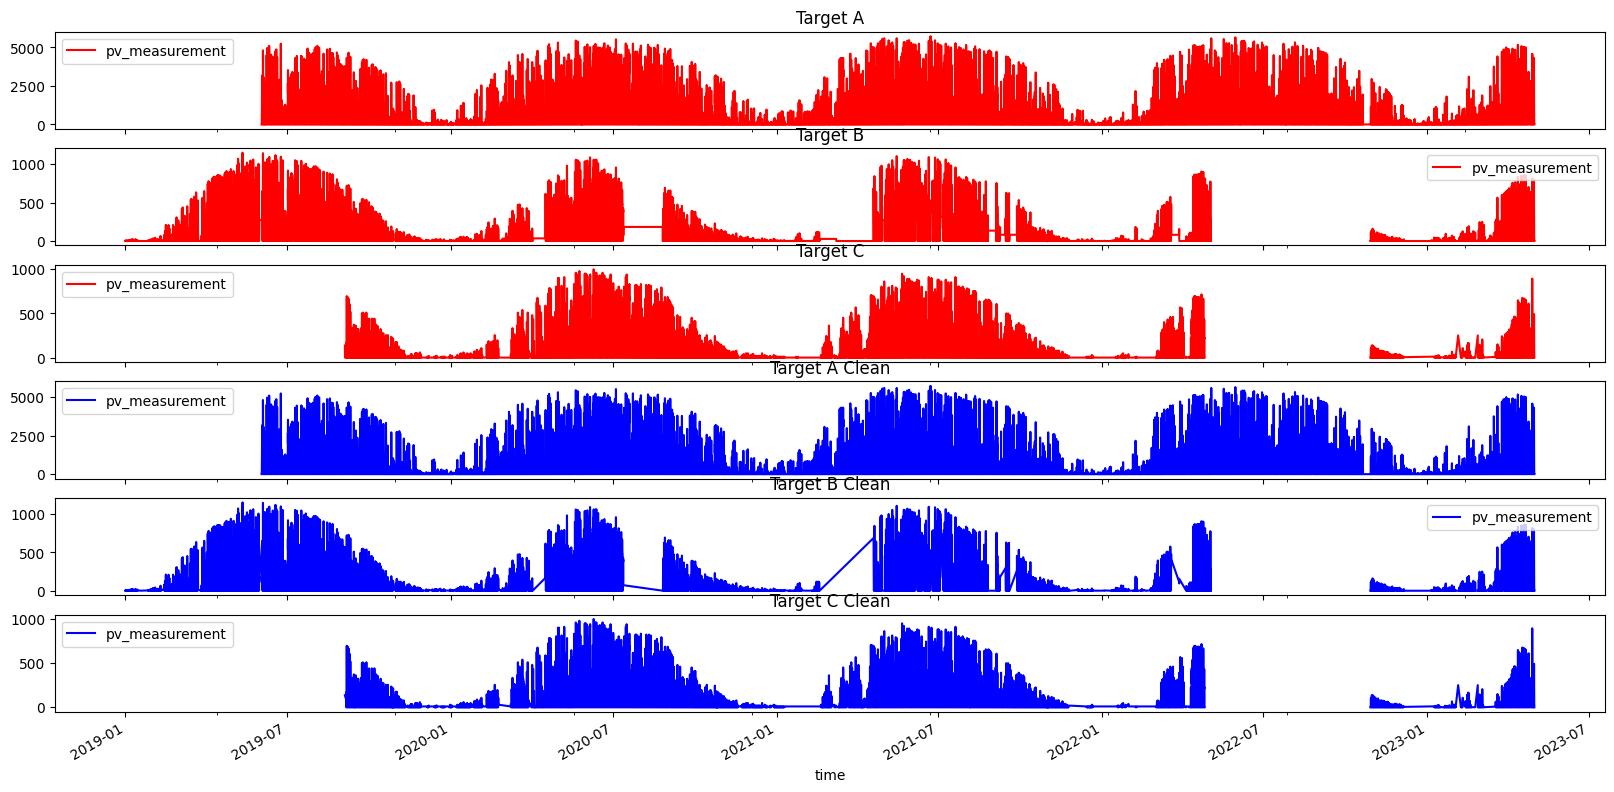

In [6]:
def fix_y_holes(y: pd.DataFrame) -> pd.DataFrame:
    Y = y
    drop_val = None
    zero_counter = 0
    index_dropper = []
    for i in range(1, len(Y)-4): # Since we match on 4 consecutive values.
        if Y['pv_measurement'].iloc[i] != 0:
            if zero_counter > 23:
                zero_list = list(range(i-zero_counter, i))
                index_dropper.extend(zero_list)
            zero_counter = 0
            if (Y['pv_measurement'].iloc[i] == Y['pv_measurement'].iloc[i+1] and Y['pv_measurement'].iloc[i+1] == Y['pv_measurement'].iloc[i+2] and Y['pv_measurement'].iloc[i+2] == Y['pv_measurement'].iloc[i+3]):
                drop_val = Y['pv_measurement'].iloc[i]
        if Y['pv_measurement'].iloc[i] == 0:
            zero_counter += 1
        if Y['pv_measurement'].iloc[i] == drop_val:
            index_dropper.append(i)
        else:
            if drop_val != None:
                drop_val = None
    print(index_dropper)
    return Y.drop(index_dropper)
    
import matplotlib.pylab as plt
fig, axs = plt.subplots(6, 1, figsize=(20, 10), sharex=True)
YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[0], title='Target A', color='red')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[1], title='Target B', color='red')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[2], title='Target C', color='red')


YA = fix_y_holes(YA)
YB = fix_y_holes(YB)
YC = fix_y_holes(YC)

YA[['time', 'pv_measurement']].set_index('time').plot(ax=axs[3], title='Target A Clean', color='blue')
YB[['time', 'pv_measurement']].set_index('time').plot(ax=axs[4], title='Target B Clean', color='blue')
YC[['time', 'pv_measurement']].set_index('time').plot(ax=axs[5], title='Target C Clean', color='blue')



# Data Aggregation

In [7]:
# Making sure that target values line up with x_values

def stocastic_median(x_list):
    s = np.median(x_list)
    return int(s)


def gen_agg(df: pd.DataFrame, agg_type, batch_size: int = 4, merge_on = 'first') -> pd.DataFrame:
    """
    Pass dataframe WITH date_forecast value and choose aggregation type by passing string to 'agg_type'
    """
    agg_func = {col: agg_type for col in df.columns[1:]} # [1:] assumes 'date_forecast' is first
    return df.groupby(df.index // batch_size).agg({**{'date_forecast': merge_on}, **agg_func})

categorical_col = ['dew_or_rime:idx', 'precip_type_5min:idx', 'is_day:idx', 'is_in_shadow:idx']

def aggregate_correct_x(x: pd.DataFrame) -> pd.DataFrame:
   '''
   Takes a given dataframe and returns an aggregated dataframe based on selected categorical functions. 
   Assumes grouping of 4.
   '''
   categorical = x[["date_forecast"] + categorical_col]
   mean = x.drop(columns=categorical_col)

   categorical = gen_agg(categorical, agg_type=stocastic_median, merge_on = 'first')
   mean = gen_agg(mean, "mean", merge_on = 'first')

   return pd.merge(categorical, mean, on="date_forecast")

def data_allign(x_train, y_train):

  y_train.dropna(inplace=True)
  x_train = aggregate_correct_x(x_train)
  combined_data = pd.merge(x_train, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns=['time', 'pv_measurement'], inplace=True)
    
  return combined_data, y_train

X_train = [XTRA, XTRB, XTRC]
Y_train = [YA, YB, YC]

for i in range(len(X_train)):
    X_train[i], Y_train[i] = data_allign(X_train[i], Y_train[i])

for j in range(len(X_frames_test)):
    X_frames_test[j] = aggregate_correct_x(X_frames_test[j])


In [8]:
#Verify length matches
for x in range(len(X_train)):
    print("x,y: ", len(X_train[x]), len(Y_train[x]))


x,y:  34017 34017
x,y:  25715 25715
x,y:  21068 21068


In [9]:
X_train[0].tail()


,date_forecast,dew_or_rime:idx,precip_type_5min:idx,is_day:idx,is_in_shadow:idx,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,estimation_calc_forecast_difference
34012,2023-04-30 19:00:00,0,0,0,1,4.55,1.27650,1674.199951,84464.945312,4.225,...,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,1.0,44545.0
34013,2023-04-30 20:00:00,0,0,0,1,4.50,1.27975,1762.400024,2270.875000,0.000,...,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,1.0,48145.0
34014,2023-04-30 21:00:00,0,0,0,1,4.50,1.28100,1696.650024,0.000000,0.000,...,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,1.0,51745.0
34015,2023-04-30 22:00:00,0,0,0,1,4.50,1.28100,1353.400024,0.000000,0.000,...,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,1.0,55345.0
34016,2023-04-30 23:00:00,0,0,0,1,4.50,1.28100,1626.574951,0.000000,0.000,...,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,1.0,58945.0


# Feature engineering

### Timeseasonality

In [10]:
from typing import List

## We now need functions for assigning daily and YEARly cycles (described in datanalysis docu on Peter branch)
# plus 2 avoids 0 and negative values but we ignore this here since it allready normalises the data
DAY = 24*60*60
YEAR = (365.2425)*DAY
SHIFT = 0 #possible to shift oscilation to avoid 0 and or negative values.

# Conversion datetime -> unix_time
def get_unixtime(datetime: pd.Series) -> pd.Series:
    unixtime = (datetime - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
    return unixtime

# functions for creating seasonality:
def sinus_day(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / DAY)) # since it is seconds since 1.1.1970 we divide by seconds in a DAY to get seasonal changes throughout the dat

def sinus_year(unix_time):
    return SHIFT + np.sin(unix_time * (2 * np.pi / YEAR))

def cosinus_day(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / DAY))

def cosinus_year(unix_time):
    return SHIFT + np.cos(unix_time * (2 * np.pi / YEAR))

# function for returning two series with the daily cycles (sine and cosine)
def get_daycycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_daytime = unixtime.apply(sinus_day)
    sinus_daytime = sinus_daytime.rename('sinus_day') 
    cosinus_daytime = unixtime.apply(cosinus_day)
    cosinus_daytime = cosinus_daytime.rename('cosinus_day')
    return [sinus_daytime, cosinus_daytime]

# Function for returning two series with the yearly cycles
def get_yearcycle(unixtime: pd.Series) -> List[pd.Series]:
    sinus_yeartime = unixtime.apply(sinus_year)
    sinus_yeartime = sinus_yeartime.rename('sinus_year')
    cosinus_yeartime = unixtime.apply(cosinus_year)
    cosinus_yeartime = cosinus_yeartime.rename('cosinus_year')
    return [sinus_yeartime, cosinus_yeartime]

def append_seasonal_columns(df: pd.DataFrame, time_column: str = 'date_forecast') -> pd.DataFrame:
    """
    returns joined Dataframe with seasonal data. Does not drop time_column
    """
    # check that time column exists
    if time_column not in df.columns: 
        raise Exception(f"The timecolumn passed: {time_column}, is not part of the dataset passed.")
    
    if not np.issubdtype(df[time_column], np.datetime64):
        raise Exception(f'Passed timecolumn must be of numpy datetime64. Passed type is {df[time_column].dtype()}')
    
    unixtime = get_unixtime(df[time_column])
    day_sin, day_cos = get_daycycle(unixtime)
    year_sin, year_cos = get_yearcycle(unixtime)
    df = df.join([day_sin, day_cos, year_sin, year_cos])
    
    return df


### One-Hot-Encoding

In [11]:

def one_hot_encode(df: pd.DataFrame, col_list: [str]):
  for col in col_list:
    column_to_encode = df[col]
    df_encoded = pd.get_dummies(column_to_encode, prefix=col) # Convert categorical variable into dummy/indicator variables
    df.drop(col, axis=1, inplace=True)
    df_encoded_binary = df_encoded.astype(int) # Convert to binary from boolean
    df = pd.concat([df, df_encoded_binary], axis=1) # Concatenate dataframes
  return df


### Date forecast columns

In [12]:
def date_forecast_columns(df: pd.DataFrame):

  date_forecast = df['date_forecast']
  
  df['year'] = date_forecast.dt.year
  df['month'] = date_forecast.dt.month
  df['day'] = date_forecast.dt.day
  df['hours'] = date_forecast.dt.hour
  df['day_of_week'] = date_forecast.dt.dayofweek
  df['day_of_year'] = date_forecast.dt.dayofyear
  df['week_of_year'] = date_forecast.dt.isocalendar().week

  return df


In [13]:
print(X_train[0].columns)


Index(['date_forecast', 'dew_or_rime:idx', 'precip_type_5min:idx',
       'is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms',

In [14]:

def more_features(df: pd.DataFrame) -> pd.DataFrame:
    # Convert the 'date_forecast' to datetime and set it as index
    df['date_forecast'] = pd.to_datetime(df['date_forecast'])
    df.set_index('date_forecast', inplace=True)
    df.sort_index(inplace=True)
    print(df.head(10))
    # Now apply the rolling function
    df['max_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').max()
    df['min_air_density_3h'] = df['air_density_2m:kgm3'].rolling('3h').min()
    df['total_solar_rad_1h'] = df['direct_rad_1h:J'] + df['diffuse_rad_1h:J']
    df['total_wind_speed_10m'] = (df['wind_speed_u_10m:ms']**2 + df['wind_speed_v_10m:ms']**2)**0.5
    df['total_snow_1h'] = df[['fresh_snow_1h:cm', 'snow_melt_10min:mm']].sum(axis=1)
    df['pressure_variation_3h'] = df['sfc_pressure:hPa'].diff(periods=3)

    return df

for i in range(len(X_train)):
    X_train[i] = append_seasonal_columns(X_train[i])
    X_train[i] = date_forecast_columns(X_train[i])


for i in range(len(X_frames_test)):
    X_frames_test[i] = append_seasonal_columns(X_frames_test[i])
    X_frames_test[i] = date_forecast_columns(X_frames_test[i])  

# THIS SECTION CAN ONLY WORK IF THE PREVIOUS AGGREGATION IS DONE INDIVIDUALLY FOR CATEGORICAL DATA

def fix_categorical(train: pd.DataFrame, test: pd.DataFrame):
    temp = pd.concat([train, test], ignore_index=True)
    index_train = temp[(temp['date_forecast'] < test['date_forecast'].iloc[0])].index
    return temp.drop(index_train)

OH_columns = ['dew_or_rime:idx', 'precip_type_5min:idx']

for i in range(len(X_frames_test)):
    X_train[i] = one_hot_encode(X_train[i],OH_columns)
    X_frames_test[i] = one_hot_encode(X_frames_test[i], OH_columns)
    X_frames_test[i] = fix_categorical(X_train[i], X_frames_test[i])
    X_train[i] = more_features(X_train[i])
    X_frames_test[i] = more_features(X_frames_test[i])


                     is_day:idx  is_in_shadow:idx  absolute_humidity_2m:gm3  \
date_forecast                                                                 
2019-06-02 22:00:00           0                 1                     7.700   
2019-06-02 23:00:00           0                 1                     7.700   
2019-06-03 00:00:00           0                 1                     7.875   
2019-06-03 01:00:00           0                 1                     8.425   
2019-06-03 02:00:00           1                 0                     8.950   
2019-06-03 03:00:00           1                 0                     9.250   
2019-06-03 04:00:00           1                 0                     9.525   
2019-06-03 05:00:00           1                 0                     9.700   
2019-06-03 06:00:00           1                 0                     9.550   
2019-06-03 07:00:00           1                 0                     9.450   

                     air_density_2m:kgm3  ceiling_h

# Data cleaning

In [15]:
# Show null values for all training sets

count_a = X_train[0].isna().sum()
count_b = X_train[1].isna().sum()
count_c = X_train[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,6126,4096,4383
cloud_base_agl:m,2362,1843,1857
snow_density:kgm3,32877,24842,21010
pressure_variation_3h,3,3,3


In [16]:
# Show null values for all test sets

count_a = X_frames_test[0].isna().sum()
count_b = X_frames_test[1].isna().sum()
count_c = X_frames_test[2].isna().sum()

count_a.rename("A", inplace=True)
count_b.rename("B", inplace=True)
count_c.rename("C", inplace=True)

df = pd.merge(count_a, count_b, left_index=True, right_index=True)
df = pd.merge(df, count_c, left_index=True, right_index=True)

df[(df['A'] != 0) | (df['B'] != 0) | (df['C'] != 0)]


,A,B,C
ceiling_height_agl:m,188,180,202
cloud_base_agl:m,70,65,88
snow_density:kgm3,720,720,720
dew_or_rime:idx_-1,720,720,0
precip_type_5min:idx_2,720,720,720
precip_type_5min:idx_3,720,720,720
pressure_variation_3h,3,3,3


In [17]:
print(X_train[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'estimate

In [18]:

def combine_features(df, listOfFeaturesToCombine):
    for features in listOfFeaturesToCombine:
        new_col_name = features[0] + '_mean'
        df[new_col_name] = df[features].mean(axis=1)
    return df

listOfFeaturesToCombine = [['msl_pressure:hPa', 'pressure_100m:hPa', 'pressure_50m:hPa', 'sfc_pressure:hPa'],
                            ["diffuse_rad:W", "direct_rad:W"], 
                           ['effective_cloud_cover:p', 'total_cloud_cover:p']
                    ]
for i in range(len(X_train)):
    X_train[i] = combine_features(X_train[i], listOfFeaturesToCombine)
    X_frames_test[i] = combine_features(X_frames_test[i], listOfFeaturesToCombine)
X_train[0].describe().transpose()

# top_10_worst_features = ['precip_type_5min:idx_5', 'wind_speed_w_1000hPa:ms', 'dew_or_rime:idx_-1', 'precip_type_5min:idx_2', 'dew_or_rime:idx_1', 'snow_drift:idx', 'dew_or_rime:idx_0', 'prob_rime:p', 'precip_type_5min:idx_3', 'fresh_snow_1h:cm',
#                          'fresh_snow_3h:cm', 'snow_melt_10min:mm', 'fresh_snow_6h:cm', 'snow_depth:cm', 'precip_type_5min:idx_1',
#                          'rain_water:kgm2', 'fresh_snow_12h:cm']
# top_5_worst_features = ['snow_drift:idx', 'dew_or_rime:idx_-1', 'dew_or_rime:idx_0', 'precip_type_5min:idx_5', 'precip_type_5min:idx_2', 
#                         'wind_speed_u_10m:ms', 'wind_speed_w_1000hPa:ms','wind_speed_v_10m:ms'
#                         ]
# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_5_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_5_worst_features, inplace=True)

# for i in range(len(X_train)):
#     X_train[i].drop(columns=top_10_worst_features, inplace=True)
#     X_frames_test[i].drop(columns=top_10_worst_features, inplace=True)


# for i in range(len(X_train)):
#     X_train[i]['diffuse_rad:W_mean_prev_hour'] = X_train[i]['diffuse_rad:W_mean'].shift(1)
#     X_train[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_train[i]['diffuse_rad_1h:J_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad:W_mean_prev_hour'] = X_frames_test[i]['diffuse_rad:W_mean'].shift(1)
#     X_frames_test[i]['diffuse_rad_1h:J_mean_prev_hour'] = X_frames_test[i]['diffuse_rad_1h:J_mean'].shift(1)




,count,mean,std,min,25%,50%,75%,max
is_day:idx,34017.0,0.486992,0.499838,0.0,0.0,0.0,1.0,1.0
is_in_shadow:idx,34017.0,0.525884,0.499337,0.0,0.0,1.0,1.0,1.0
absolute_humidity_2m:gm3,34017.0,6.324186,2.800683,0.7,4.2,5.825,8.25,17.35
air_density_2m:kgm3,34017.0,1.253254,0.037221,1.145,1.2275,1.2515,1.27725,1.42625
ceiling_height_agl:m,27891.0,2977.367676,2565.257568,27.849998,1128.275024,1981.275024,4177.325195,12294.901367
...,...,...,...,...,...,...,...,...
total_snow_1h,34017.0,0.00754,0.083724,0.0,0.0,0.0,0.0,3.55
pressure_variation_3h,34014.0,0.000786,1.566613,-21.875,-0.800049,0.025024,0.849976,13.199951
msl_pressure:hPa_mean,34017.0,1004.528687,12.68611,939.75,996.612488,1005.474976,1013.331177,1038.943726
diffuse_rad:W_mean,34017.0,47.409863,79.703354,0.0,0.0,1.1,63.887497,386.637512


In [19]:
print(X_frames_test[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'air_density_2m:kgm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J',
       'clear_sky_rad:W', 'cloud_base_agl:m', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'msl_pressure:hPa', 'precip_5min:mm',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'estimate

In [21]:
X_train_ag = [X_train[0].__deepcopy__(), X_train[1].__deepcopy__(), X_train[2].__deepcopy__()]
X_frames_test_ag = [X_frames_test[0].__deepcopy__(), X_frames_test[1].__deepcopy__(), X_frames_test[2].__deepcopy__()]


In [22]:
def multiply_columns(A: pd.Series, B: pd.Series) -> pd.Series:
    '''
    Given two pandas series, returns a series with multiplied values. 

    NB! Series A and B must be of same length
    '''

    if len(A) != len(B): 
        raise Exception("In multiply columns -> length of series is not equal")
    
    C = A*B

    return C


In [23]:
## Multiplying effective cloud coverage with clear sky radiation

def flip_percent(x):
    return (x-100)*-1

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    B = X_train_ag[i]['clear_sky_rad:W']
    AT = X_frames_test_ag[i]['effective_cloud_cover:p'].apply(flip_percent)
    BT = X_frames_test_ag[i]['clear_sky_rad:W']

    X_train_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_clear_sky_rad_X_eff_cloud_cover'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['clear_sky_rad:W', 'clear_sky_energy_1h:J'])


In [24]:
from math import sin, radians

def sinus_degrees(x):
    return sin(radians(x))

for i in range(len(X_train_ag)):
    A = X_train_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    B = X_train_ag[i]['air_density_2m:kgm3']
    AT = X_frames_test_ag[i]['sun_elevation:d'].apply(sinus_degrees)
    BT = X_frames_test_ag[i]['air_density_2m:kgm3']

    X_train_ag[i]['COMB_sun_elevation_air_density'] = multiply_columns(A, B)
    X_frames_test_ag[i]['COMB_sun_elevation_air_density'] =  multiply_columns(AT, BT)
    X_train_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)
    X_frames_test_ag[i].drop(columns=['air_density_2m:kgm3'], inplace=True)


In [25]:
def flip_ceiling_height(x):
    flip_val = 12005.7
    null_dist = 1000
    return abs(x-(flip_val+null_dist))

for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['ceiling_height_agl:m'] = X_frames_test_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['ceiling_height_agl:m']= X_train_ag[i]['ceiling_height_agl:m'].apply(flip_ceiling_height)


In [26]:
def flip_cloud_base(x):
    flip_val = 11467.8
    null_dist = 1000
    return abs(x-(flip_val+null_dist))
for i in range(len(X_train_ag)):
    X_frames_test_ag[i]['cloud_base_agl:m'] = X_frames_test_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)
    X_train_ag[i]['cloud_base_agl:m']= X_train_ag[i]['cloud_base_agl:m'].apply(flip_ceiling_height)


In [27]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 0, "cloud_base_agl:m": 0}

for i in range(len(X_train_ag)):
    X_train_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_frames_test_ag[i].drop(columns=['snow_density:kgm3', 'elevation:m'], inplace=True)
    X_train_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(value=values, inplace=True)
    X_frames_test_ag[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [28]:
# Removes nan or fills it
values = {"ceiling_height_agl:m": 20000, "cloud_base_agl:m": 20000}

for i in range(len(X_train)):
    X_train[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_frames_test[i].drop(columns=['snow_density:kgm3', 'elevation:m', 'year'], inplace=True)
    X_train[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(value=values, inplace=True)
    X_frames_test[i].fillna(0, inplace=True) # fills remaining NaN vals with 0, (specifically for one-hot encoded columns with NaN)


In [29]:
print(X_train_ag[0].columns)


Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinus_day', 'co

# Training the model

### Catboost

In [88]:



# Use params from hyperparameter tuning using optuna
params_a = {'random_state': 42, 'learning_rate': 0.039975576144155645, 'depth': 9, 'subsample': 0.4504678933801176, 'colsample_bylevel': 0.9773225861097778, 'min_data_in_leaf': 90}
params_b = {'random_state': 42, 'learning_rate': 0.023765834908014156, 'depth': 10, 'subsample': 0.8298593330195755, 'colsample_bylevel': 0.6060393047650714, 'min_data_in_leaf': 61}
params_c = {'random_state': 42, 'learning_rate': 0.060183973978509046, 'depth': 10, 'subsample': 0.28819995411353627, 'colsample_bylevel': 0.39818319507473743, 'min_data_in_leaf': 77}

model_a = CatBoostRegressor(**params_a)
model_b = CatBoostRegressor(**params_b)
model_c = CatBoostRegressor(**params_c)


model_a.fit(X_train[0], Y_train[0])
model_b.fit(X_train[1], Y_train[1])
model_c.fit(X_train[2], Y_train[2])


0:	learn: 1129.8808097	total: 18ms	remaining: 18s
1:	learn: 1094.6855691	total: 33.2ms	remaining: 16.6s
2:	learn: 1060.8615167	total: 48.8ms	remaining: 16.2s
3:	learn: 1028.2402807	total: 60.6ms	remaining: 15.1s
4:	learn: 997.7289423	total: 76.7ms	remaining: 15.3s
5:	learn: 968.2895321	total: 89.1ms	remaining: 14.8s
6:	learn: 940.4665009	total: 104ms	remaining: 14.8s
7:	learn: 913.6282429	total: 116ms	remaining: 14.4s
8:	learn: 888.0770208	total: 131ms	remaining: 14.4s
9:	learn: 863.1856900	total: 143ms	remaining: 14.2s
10:	learn: 839.7645581	total: 158ms	remaining: 14.2s
11:	learn: 817.2752952	total: 169ms	remaining: 13.9s
12:	learn: 795.9304923	total: 181ms	remaining: 13.8s
13:	learn: 775.8564040	total: 197ms	remaining: 13.9s
14:	learn: 756.9498807	total: 212ms	remaining: 13.9s
15:	learn: 738.7458553	total: 227ms	remaining: 13.9s
16:	learn: 721.6413193	total: 240ms	remaining: 13.9s
17:	learn: 705.3510928	total: 252ms	remaining: 13.7s
18:	learn: 689.9628353	total: 267ms	remaining: 13.

In [31]:
print(Y_train[0].head())


0     0.00
1     0.00
2     0.00
3     0.00
4    19.36
Name: pv_measurement, dtype: float64


### AutoGluon

In [55]:
for i in range(len(X_train_ag)):
    X_train_ag[i].drop(columns=['date_forecast', 'index'], inplace=True)

In [56]:
X_train_ag[0].columns

Index(['level_0', 'is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_speed_10m:ms', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
       'wind_speed_w_1000hPa:ms', 'estimated',
       'estimation_calc_forecast_difference', 'sinu

In [45]:
def combine_all_frames(frames: [pd.DataFrame]):
    
    for i, frame in enumerate(frames):
        if i == 0:
            frame['location'] = '0'
        elif i == 1:
            frame['location'] = '1'
        elif i == 2:
            frame['location'] = '2'
    combined = pd.concat(frames)
    combined = combined.reset_index(drop=True)
    combined['location'] = combined['location'].astype('float64')

    return combined

def combine_series(series: [pd.Series]) -> pd.Series:
    combined = pd.concat(series)
    combined.reset_index(drop=True, inplace=True)
    return combined

In [60]:
print(Y_train[0].head(10))

for i in range(len(X_train_ag)):
    X_train_ag[i].reset_index(drop=True, inplace=True)
    
X_comb = combine_all_frames(X_train_ag)
NYA=(Y_train[0]-Y_train[0].mean())/Y_train[0].std()
NYB=(Y_train[1]-Y_train[1].mean())/Y_train[1].std()
NYC=(Y_train[2]-Y_train[2].mean())/Y_train[2].std()
Y_comb = combine_series([NYA, NYB, NYC])
Y_comb.reset_index(drop=True, inplace=True)
print(X_train_ag[0].columns)

0       0.00
1       0.00
2       0.00
3       0.00
4      19.36
5     251.02
6     263.78
7     522.72
8     904.42
9    1238.82
Name: pv_measurement, dtype: float64
Index(['is_day:idx', 'is_in_shadow:idx', 'absolute_humidity_2m:gm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_point_2m:K', 'diffuse_rad:W',
       'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'fresh_snow_12h:cm', 'fresh_snow_1h:cm',
       'fresh_snow_24h:cm', 'fresh_snow_3h:cm', 'fresh_snow_6h:cm',
       'msl_pressure:hPa', 'precip_5min:mm', 'pressure_100m:hPa',
       'pressure_50m:hPa', 'prob_rime:p', 'rain_water:kgm2',
       'relative_humidity_1000hPa:p', 'sfc_pressure:hPa', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d', 'super_cooled_liquid_water:kgm2',
       't_1000hPa:K', 'total_cloud_cover:p', 'visibility:m',
       'wind_spe

In [59]:
X_train_ag[0].drop(columns=['level_0'], inplace=True)

In [46]:
from autogluon.tabular import TabularDataset, TabularPredictor



joined = pd.merge(X_comb, Y_comb, left_index=True, right_index=True)
train = TabularDataset(joined)
predictor = TabularPredictor(label="pv_measurement", eval_metric='mae').fit(train_data=train, presets='best_quality', time_limit=7200) #, presets='good_quality', time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20231112_014300"
Presets specified: ['best_quality']
/Users/peterlawrence/Repos/TDT4173-ML/venv/lib/python3.11/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 7200s
AutoGluon will save models to "AutogluonModels/ag-20231112_014300"
AutoGluon Version:  0.8.3b20231106
Python Version:     3.11.1
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.1.0: Sun Oct  9 20:15:09 PDT 2022; root:xnu-8792.41.9~2/RELEASE_ARM64_T6000
Disk Space Avail:   352.08 GB / 994.66 GB (35.4%)
Train Data Rows:    80800
Train Data Columns: 

0       0.00
1       0.00
2       0.00
3       0.00
4      19.36
5     251.02
6     263.78
7     522.72
8     904.42
9    1238.82
Name: pv_measurement, dtype: float64


Cannot interpret 'UInt32Dtype()' as a data type
	Stage 3 Generators:
		Fitting IdentityFeatureGenerator...
	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Unused Original Features (Count: 1): ['week_of_year']
		These features were not used to generate any of the output features. Add a feature generator compatible with these features to utilize them.
		Features can also be unused if they carry very little information, such as being categorical but having almost entirely unique values or being duplicates of other features.
		These features do not need to be present at inference time.
		('UInt32', []) : 1 | ['week_of_year']
	Types of features in original data (raw dtype, special dtypes):
		('float', []) : 57 | ['absolute_humidity_2m:gm3', 'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W', 'cloud_base_agl:m', ...]
		('int', [])   : 16 | ['index', 'is_day:idx', 'is_in_shadow:idx', 'year', 'month'

# Evaluate prediction

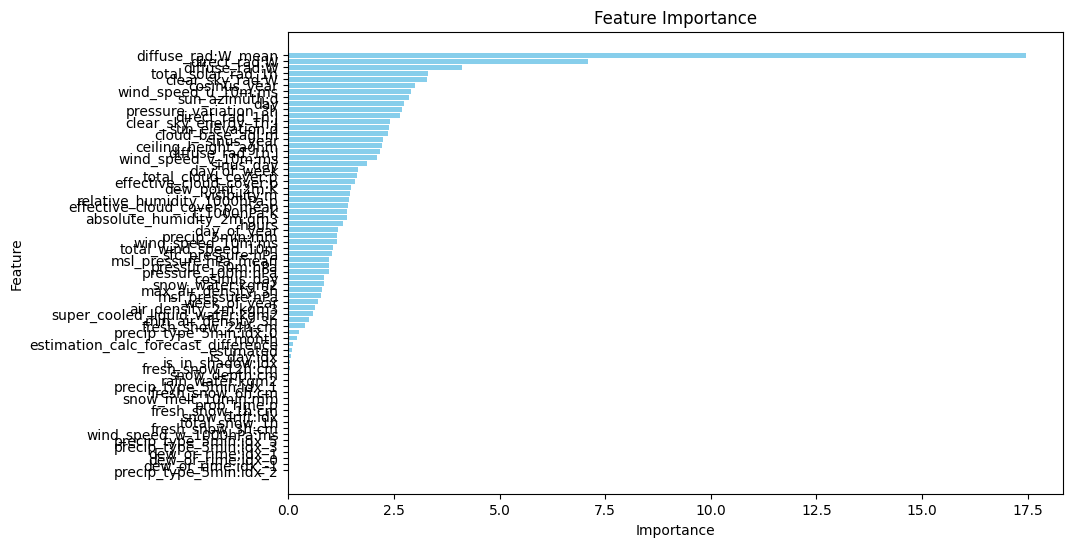

In [47]:
# Feature importance catboost

import matplotlib.pyplot as plt

feature_importance = model_a.get_feature_importance()
# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': X_train[0].columns, 'Importance': feature_importance})

# Sort the DataFrame by importance scores in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot to visualize feature importance

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
plt.show()


In [48]:
# Feature importance autogluon

# import matplotlib.pyplot as plt

# feature_importance = predictor.feature_importance()

# # Create a DataFrame to store feature names and their importance scores
# importance_df = pd.DataFrame({'Feature': X_train_ag[0].columns, 'Importance': feature_importance})

# # Sort the DataFrame by importance scores in descending order
# importance_df = importance_df.sort_values(by='Importance', ascending=False)

# # Create a bar plot to visualize feature importance

# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
# plt.xlabel('Importance')
# plt.ylabel('Feature')
# plt.title('Feature Importance')
# plt.gca().invert_yaxis()  # Invert the y-axis to display the most important features at the top
# plt.show()


# Make predictions

In [49]:
def upscale(val, location: int):
    return (val * Y_train[location].std())+Y_train[location].mean()

In [89]:
# Train the model on the entire training data

y_pred_cat_a = model_a.predict(X_frames_test[0]) * X_frames_test[0]['is_day:idx']
y_pred_cat_b = model_b.predict(X_frames_test[1]) * X_frames_test[1]['is_day:idx']
y_pred_cat_c = model_c.predict(X_frames_test[2]) * X_frames_test[2]['is_day:idx']

x_test_comb = combine_all_frames(X_frames_test_ag)
x_test_comb['index'] = range(len(x_test_comb))
pred_test = predictor.predict(x_test_comb)

a_ind_test = x_test_comb[x_test_comb['location'] == 0].index
b_ind_test = x_test_comb[x_test_comb['location'] == 1].index
c_ind_test = x_test_comb[x_test_comb['location'] == 2].index

y_pred_ag_a = upscale(pred_test[a_ind_test], 0)#* X_frames_test_ag[0]['is_day:idx']
y_pred_ag_b = upscale(pred_test[b_ind_test], 1)#* X_frames_test_ag[1]['is_day:idx']
y_pred_ag_c = upscale(pred_test[c_ind_test], 2)#* X_frames_test_ag[2]['is_day:idx']

y_pred_cat = np.concatenate((y_pred_cat_a, y_pred_cat_b, y_pred_cat_c), axis=0)
y_pred_ag = np.concatenate((y_pred_ag_a, y_pred_ag_b, y_pred_ag_c), axis=0)


In [75]:
len(y_pred_ag_a)

720

### Combine predictions

In [90]:

mean_of_predictions = (y_pred_cat + y_pred_ag) / 2
y_pred = mean_of_predictions


In [91]:
print(len(y_pred_cat))
print(len(y_pred_ag))


2160
2160


In [92]:
for i in range(len(y_pred)):
    if i < 720:
        if y_pred[i] < 20: 
            y_pred[i] = 0
    else:
        if y_pred[i] < 10: 
            y_pred[i] = 0
    if i < 720:
        if y_pred_cat[i] < 20: 
            y_pred_cat[i] = 0
    else:
        if y_pred_cat[i] < 10: 
            y_pred_cat[i] = 0



# Create submission

In [79]:
y_test_pred = y_pred

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_SH1_cat_ag.csv', index=False)


In [93]:
y_test_pred = y_pred_cat

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_SH1_cat_2.csv', index=False)

In [81]:
y_test_pred = y_pred_ag

test = pd.read_csv('../data/test.csv')
test['prediction'] = y_test_pred
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submissions/submission_SH1_ag.csv', index=False)

(2160,)
(2160,)


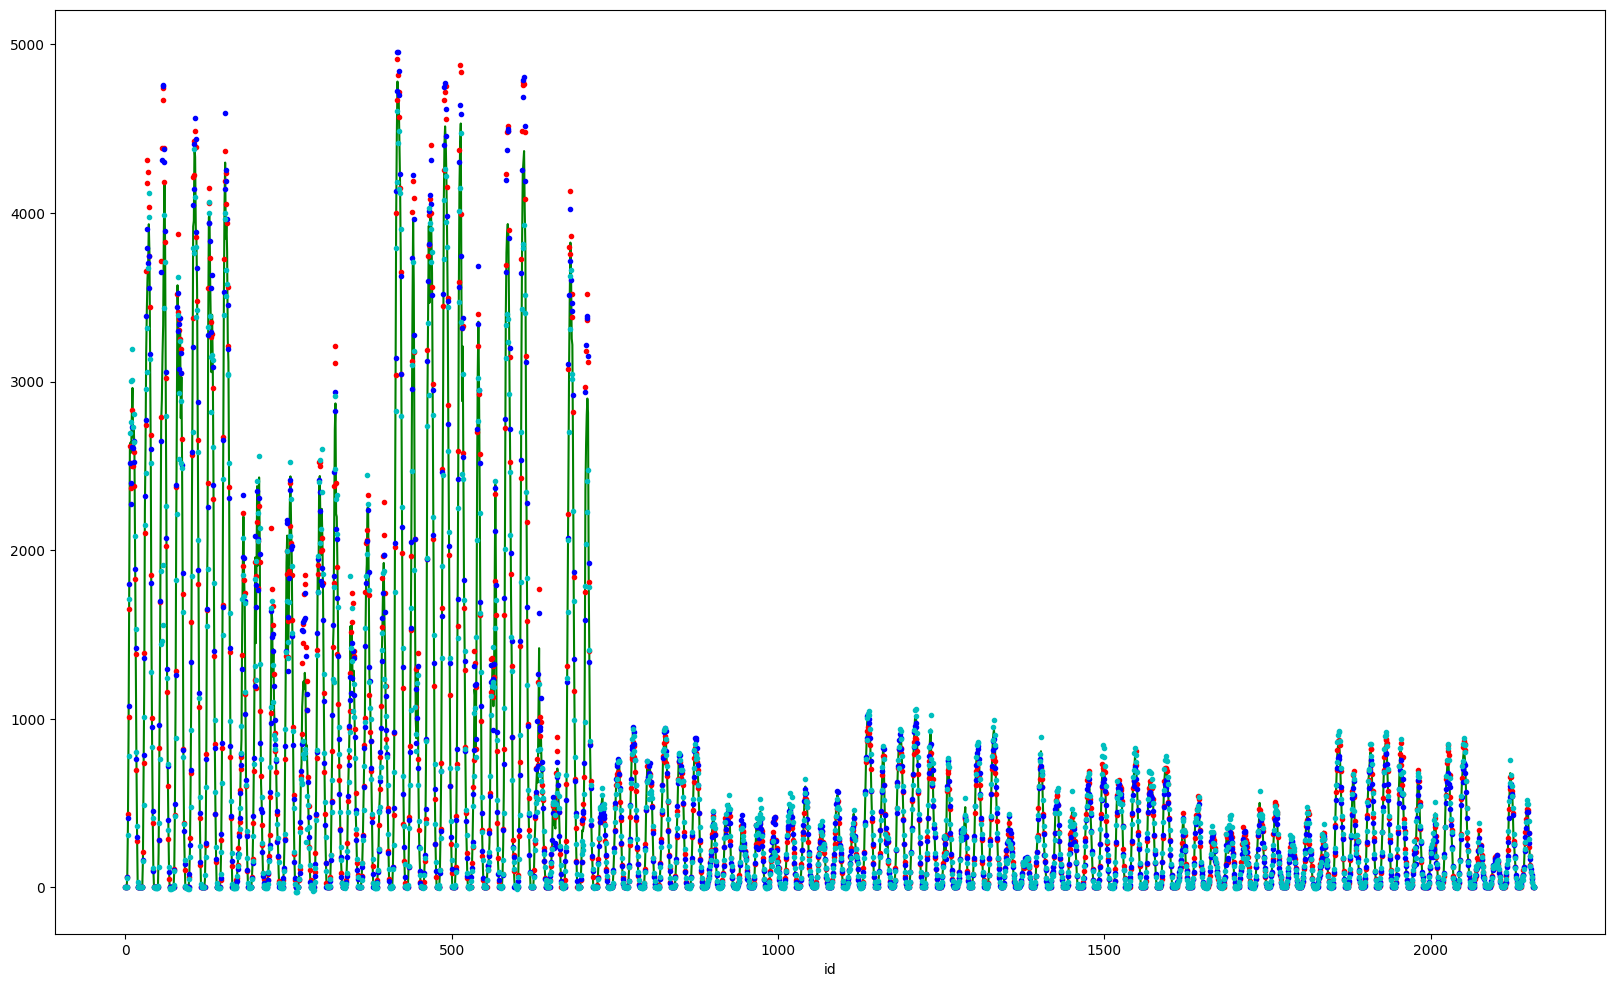

In [94]:
best_submission = pd.read_csv('../model_notebooks/submissions/submission_cat.csv')
second_best_sub = pd.read_csv('./submissions/submission_SH1_cat_ag.csv')
ag = pd.read_csv('./submissions/submission_SH1_ag.csv')
cat = pd.read_csv('./submissions/submission_SH1_cat.csv')
cat_2 = pd.read_csv('./submissions/submission_SH1_cat_2.csv')

print(y_pred.shape)
print(best_submission['prediction'].shape)
plt.figure(figsize=(20,12))

plt.plot(second_best_sub['prediction'], 'g')
plt.plot(best_submission['prediction'], 'r.')
plt.plot(cat['prediction'], 'b.')
plt.plot(ag['prediction'], 'c.')
plt.xlabel("id")
plt.show()


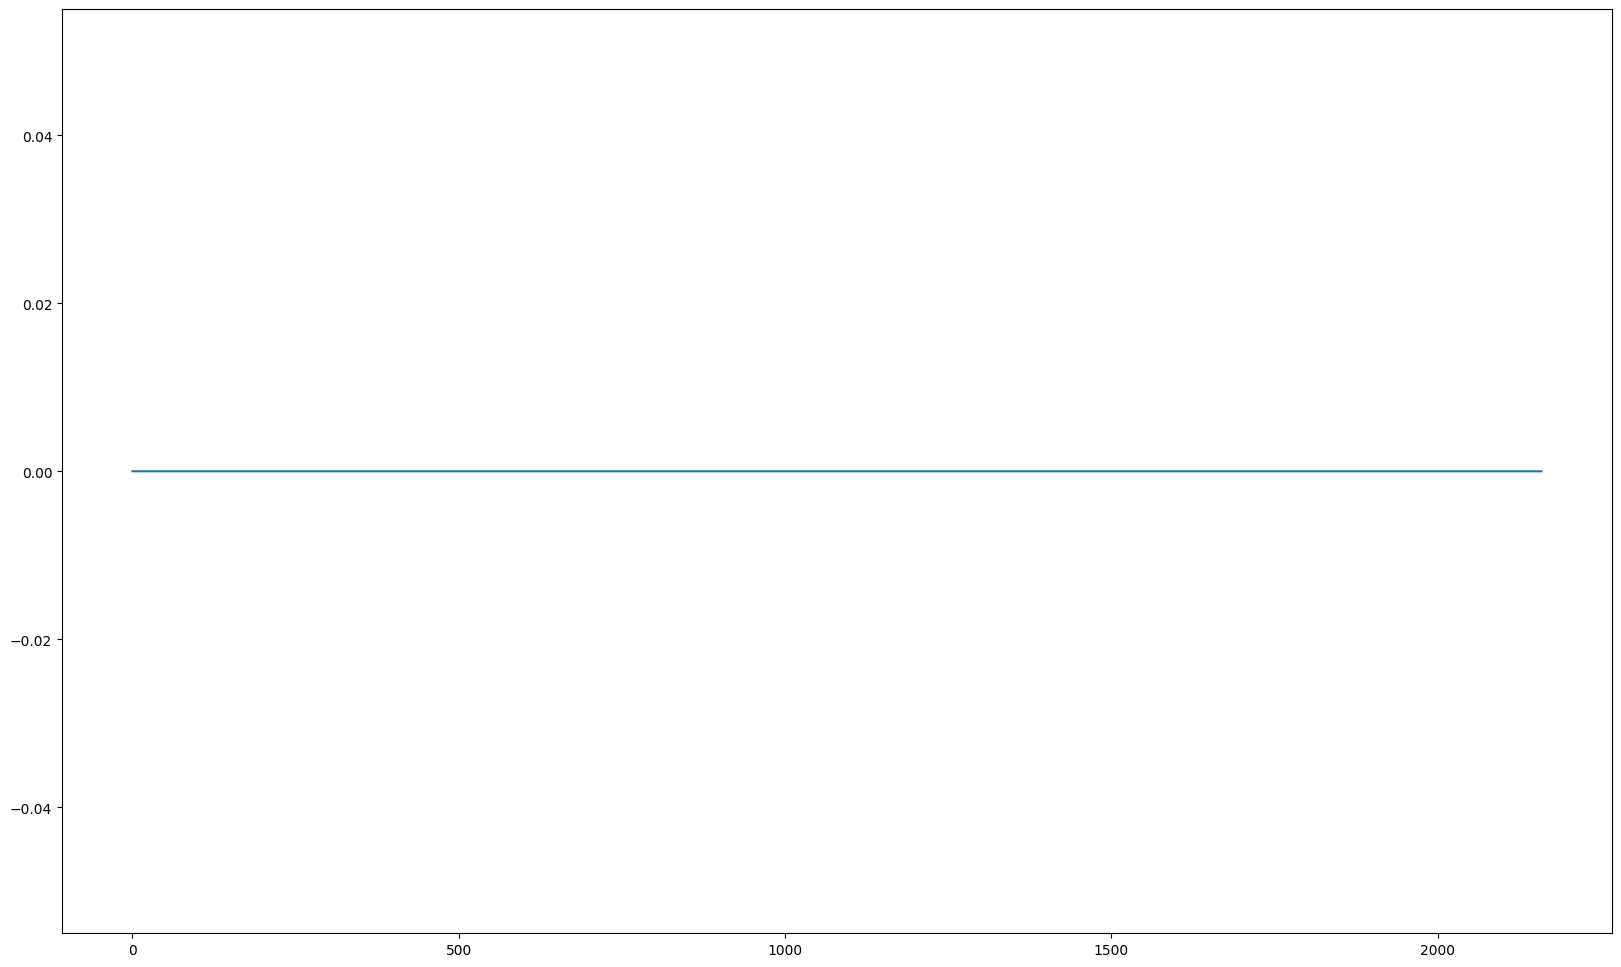

In [95]:
diff_cat = cat_2['prediction']-cat['prediction']
plt.figure(figsize=(20,12))
plt.plot(diff_cat)

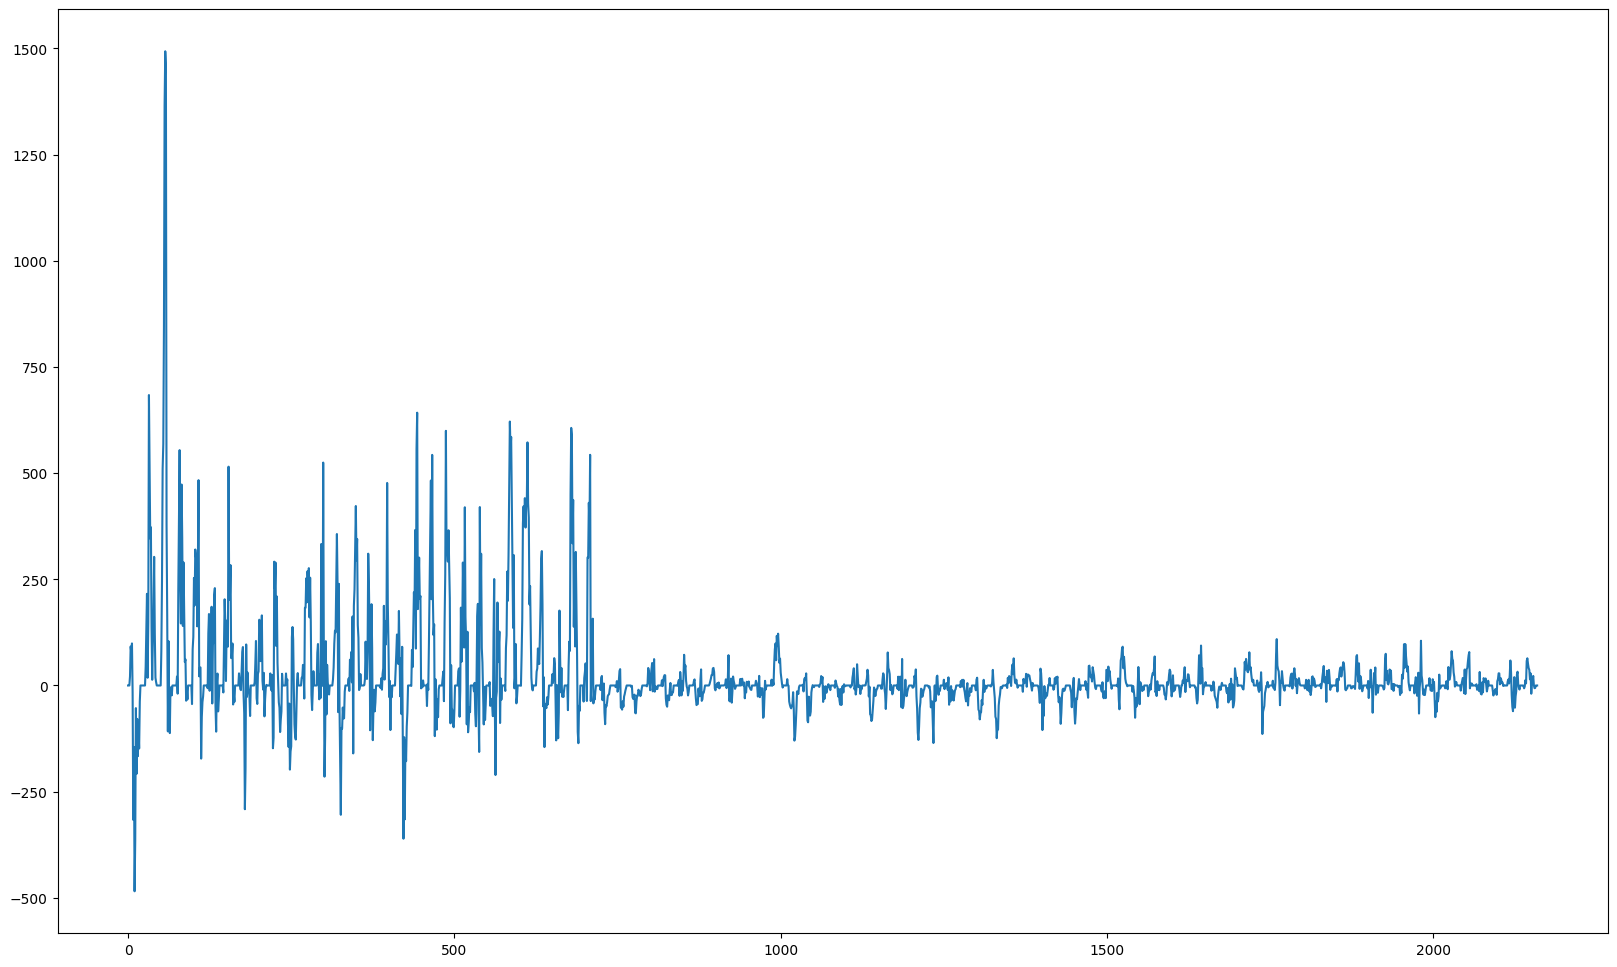

In [84]:
dist = best_submission['prediction'] - second_best_sub['prediction']

plt.figure(figsize=(20,12))
plt.plot(dist)


In [96]:
abs(dist).mean()

47.84609837256879